In [28]:
!pip install bayesian-optimization

In [29]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import warnings
import numpy as np
from numpy import array
from importlib import reload # to reload modules if we made changes to them without restarting kernel
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

In [30]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score, accuracy_score
from pandas.plotting import autocorrelation_plot

In [31]:
import tensorflow.keras as keras
from tensorflow.python.keras.optimizer_v2 import rmsprop
from functools import partial
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, TimeDistributed, LSTM, Dense, Bidirectional, Dropout, ConvLSTM2D, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Convolution1D, BatchNormalization, LeakyReLU
# Hyper Parameters Tuning with Bayesian Optimization (> pip install bayesian-optimization)
from bayes_opt import BayesianOptimization

from tensorflow.keras.utils import plot_model

In [38]:
import ml_helper_functions
import plotting_helper

In [41]:
import warnings
warnings.filterwarnings('ignore')

In [32]:
files = os.listdir('stocks')
stocks = {}
for file in files:
    # Include only csv files
    if file.split('.')[1] == 'csv':
        name = file.split('.')[0]
        stocks[name] = pd.read_csv('stocks/'+file, index_col='Date')
        stocks[name].index = pd.to_datetime(stocks[name].index)

In [33]:
print('Reliance historical data contains {} entries'.format(stocks['reliance'].shape[0]))
stocks['reliance'][['Return']].head()

Reliance historical data contains 1214 entries


,Return
Date,
2016-11-30,-0.010
2016-12-01,-0.002
2016-12-02,-0.001
2016-12-05,-0.001
2016-12-06,0.009


#ARIMA

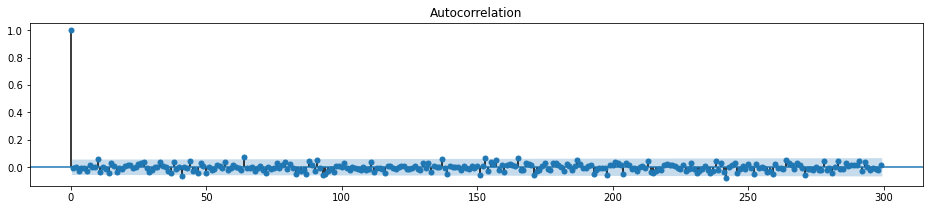

In [34]:
plt.rcParams['figure.figsize'] = (16, 3)
plot_acf(stocks['reliance'].Return, lags=range(300))
plt.show()

In [43]:
# ARIMA orders
orders = [(0,0,0),(1,0,0),(0,1,0),(0,0,1),(1,1,0)]

# Splitting into train and test sets
train = list(stocks['reliance']['Return'][0:900].values)
test = list(stocks['reliance']['Return'][900:1200].values)

all_predictions = {}

for order in orders:
    
    try:
        # History will contain original train set, 
        # but with each iteration we will add one datapoint
        # from the test set as we continue prediction
        history = train.copy()
        order_predictions = []
        
        for i in range(len(test)):
            
            model = ARIMA(history, order=order) # defining ARIMA model
            model_fit = model.fit(disp=0) # fitting model
            y_hat = model_fit.forecast() # predicting 'return'
            order_predictions.append(y_hat[0][0]) # first element ([0][0]) is a prediction
            history.append(test[i]) # simply adding following day 'return' value to the model    
            print('Prediction: {} of {}'.format(i+1,len(test)), end='\r')
        
        accuracy = accuracy_score( 
            ml_helper_functions.binary(test), 
            ml_helper_functions.binary(order_predictions) 
        )        
        print('                             ', end='\r')
        print('{} - {:.1f}% accuracy'.format(order, round(accuracy, 3)*100), end='\n')
        all_predictions[order] = order_predictions
    
    except:
        print(order, '<== Wrong Order', end='\n')
        pass

(0, 0, 0) - 60.3% accuracy
(1, 0, 0) - 54.0% accuracy
(0, 1, 0) - 49.3% accuracy
(0, 0, 1) - 53.7% accuracy
(1, 1, 0) - 52.0% accuracy


In [54]:
print ('Actual ->', test )
for prediction in all_predictions:
  print(prediction, '->', all_predictions[prediction])

Actual -> [0.01, -0.037000000000000005, 0.005, -0.022000000000000002, -0.021, 0.064, -0.02, -0.011000000000000001, 0.008, -0.018000000000000002, -0.0, 0.003, -0.003, -0.004, -0.006, 0.016, -0.004, -0.011000000000000001, -0.017, 0.002, -0.011000000000000001, 0.025, -0.017, -0.002, -0.043, -0.006, 0.017, -0.006999999999999999, -0.003, -0.001, 0.006999999999999999, 0.037000000000000005, 0.06, 0.003, -0.01, 0.003, 0.002, -0.009000000000000001, -0.004, -0.019, -0.028999999999999998, -0.013000000000000001, -0.012, 0.006, -0.005, 0.009000000000000001, -0.011000000000000001, -0.017, -0.013999999999999999, -0.006999999999999999, 0.01, -0.009000000000000001, -0.001, 0.001, 0.022000000000000002, 0.004, -0.036000000000000004, -0.018000000000000002, -0.006, -0.011000000000000001, -0.02, -0.01, 0.003, -0.035, -0.0, -0.015, 0.015, 0.01, -0.07400000000000001, -0.021, 0.040999999999999995, 0.0, 0.02, -0.006, 0.004, -0.044000000000000004, -0.001, 0.006999999999999999, -0.044000000000000004, -0.003, -0.0

Text(0, 0.5, 'Returns')

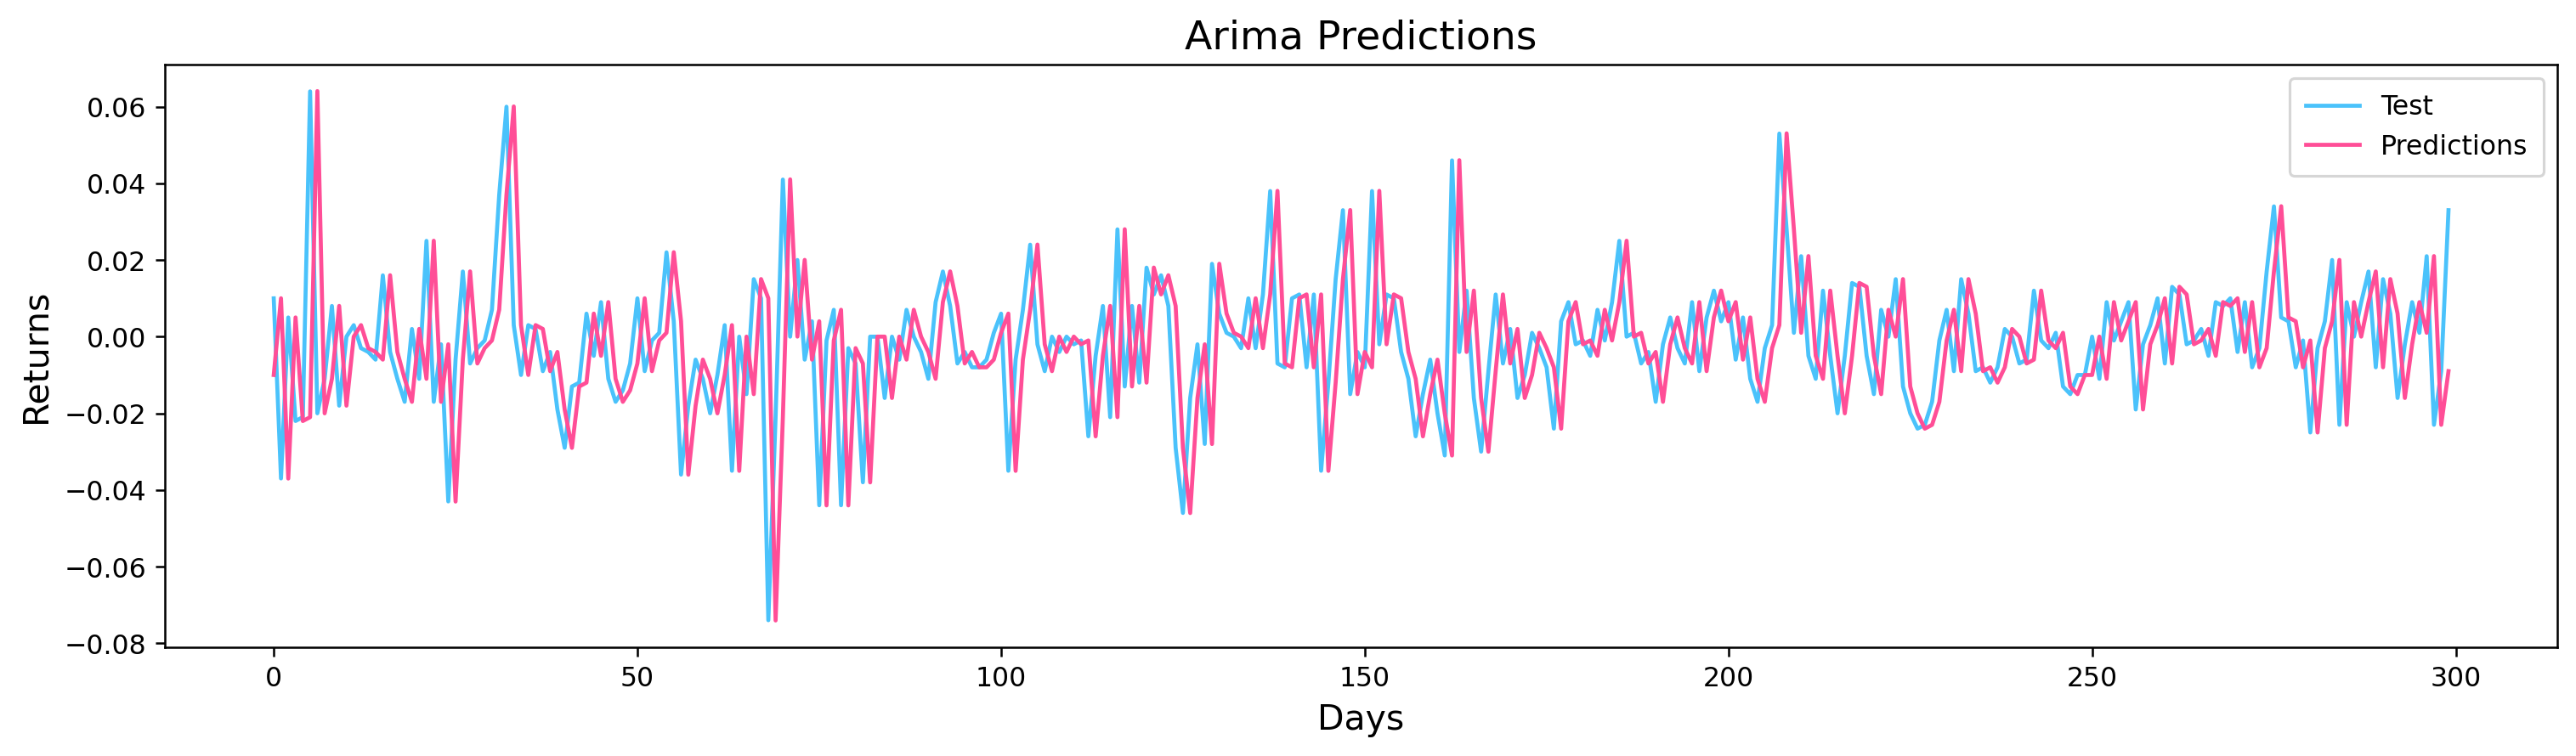

In [50]:
# Big Plot
fig = plt.figure(figsize=(16,4))
plt.plot(test, label='Test', color='#4ac2fb')
plt.plot(all_predictions[(0,1,0)], label='Predictions', color='#ff4e97')
plt.legend(frameon=True, loc=1, ncol=1, fontsize=10, borderpad=.6)
plt.title('Arima Predictions', fontSize=15)
plt.xlabel('Days', fontSize=13)
plt.ylabel('Returns', fontSize=13)

In [58]:
test_binary = ml_helper_functions.binary(stocks['reliance'][900:1200].reset_index().Return)
train_binary = ml_helper_functions.binary(all_predictions[(1,0,0)])
tn, fp, fn, tp = confusion_matrix(test_binary, train_binary).ravel()
accuracy = accuracy_score(test_binary, train_binary)

print("True positive and Negative: {}".format((tp + tn)))
print("False Positive and Negative: {}".format((fp + fn)))
print("Accuracy: {:.1f}%".format(accuracy*100))

True positive and Negative: 162
False Positive and Negative: 138
Accuracy: 54.0%


#Features selection with XGBoost

In [60]:
scaled_rel = ml_helper_functions.scale(stocks['reliance'], scale=(0,1))

In [65]:
X = scaled_rel[:-1]
y = stocks['reliance'].Return.shift(-1)[:-1]

print(len(X))
print(len(y))

1213
1213


In [66]:
xgb = XGBClassifier()
xgb.fit(X[900:], y[900:])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

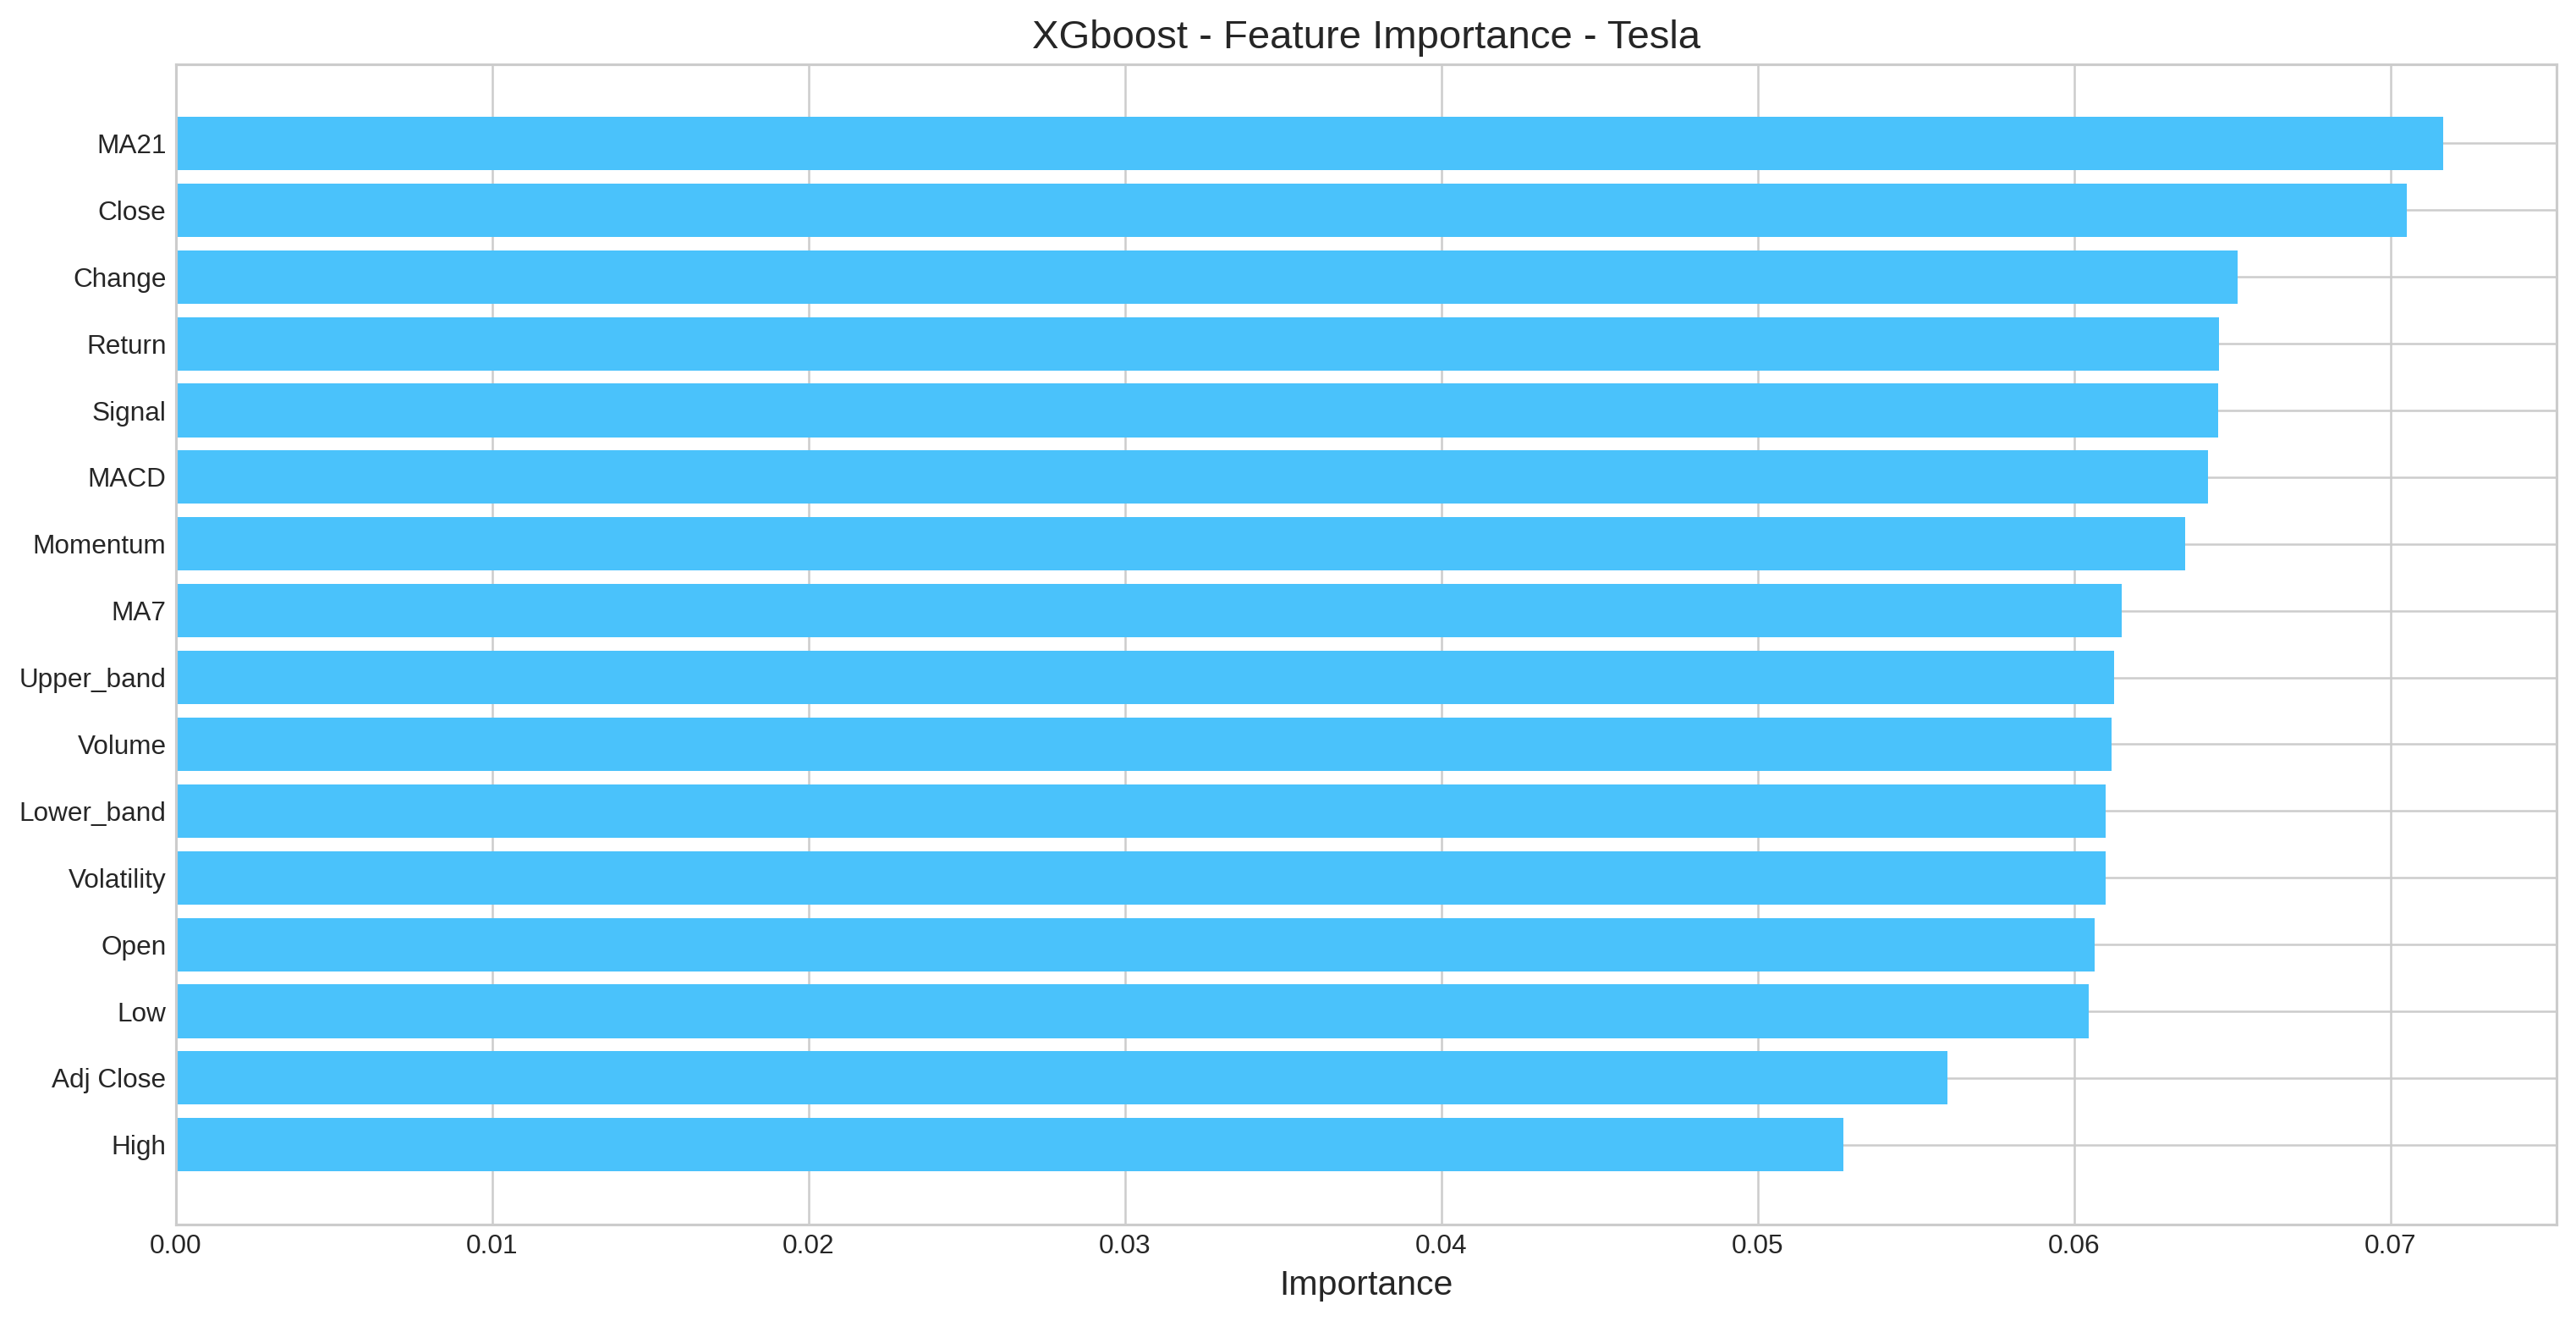

In [67]:
important_features = pd.DataFrame({
                                    'Feature': X.columns, 
                                    'Importance': xgb.feature_importances_}) \
                                    .sort_values('Importance', ascending=True)

plt.figure(figsize=(16,8))
plt.style.use('seaborn-whitegrid')
plt.barh(important_features.Feature, important_features.Importance, color="#4ac2fb")
plt.title('XGboost - Feature Importance - Tesla', fontSize=15)
plt.xlabel('Importance', fontSize=13)
plt.show()